# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Для реализации поставленных целей необходимо построить модель, которая по фотографии будет определять приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Проведем исследовательский анализ данных:

- Посмотрим на размер выборки.

- Построим график распределения возраста в выборке.

- Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

Сделаем выводы о том, как результаты исследования повлияют на обучение модели.

Построим модель, обучим ее. Определим качество построенной модели на основе метрики МАЕ.

## Импорт бибилиотек

In [1]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Загрузка и анализ данных

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv') #импортируем данные по возрасту

print('Размер выборки', labels.shape) #определяем размер выборки

Размер выборки (7591, 2)


Размер выборки показывает наличие 7591 фото, это небольшая выборка для обучения модели по определению возраста и решения задач, поставленных булочной. Однако, попробуем нарастить  ее, применяя аугментацию horizontal_flip=True.

Text(0.5, 1.0, 'График распределения возраста в выборке')

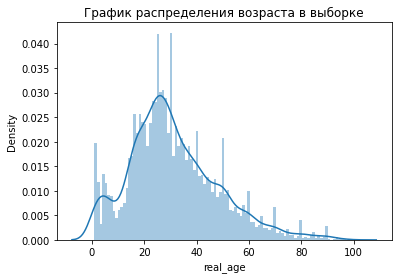

In [3]:
# строим график распределения возраста в выборке
warnings.filterwarnings('ignore')
sns_plot = sns.distplot(labels['real_age'], bins = 100)
plt.title("График распределения возраста в выборке")

Выбросов не обнаружено. Можно увидеть небольшой скачок в количестве фото людей до 15 лет. Также представленное количество фотографий распределено неравномерно по возрасту.

Судя по графику распределения возраста в выборке представленые данные - корректные, аномальных значений по возрасту не выявлено.

Found 7591 images belonging to 1 classes.


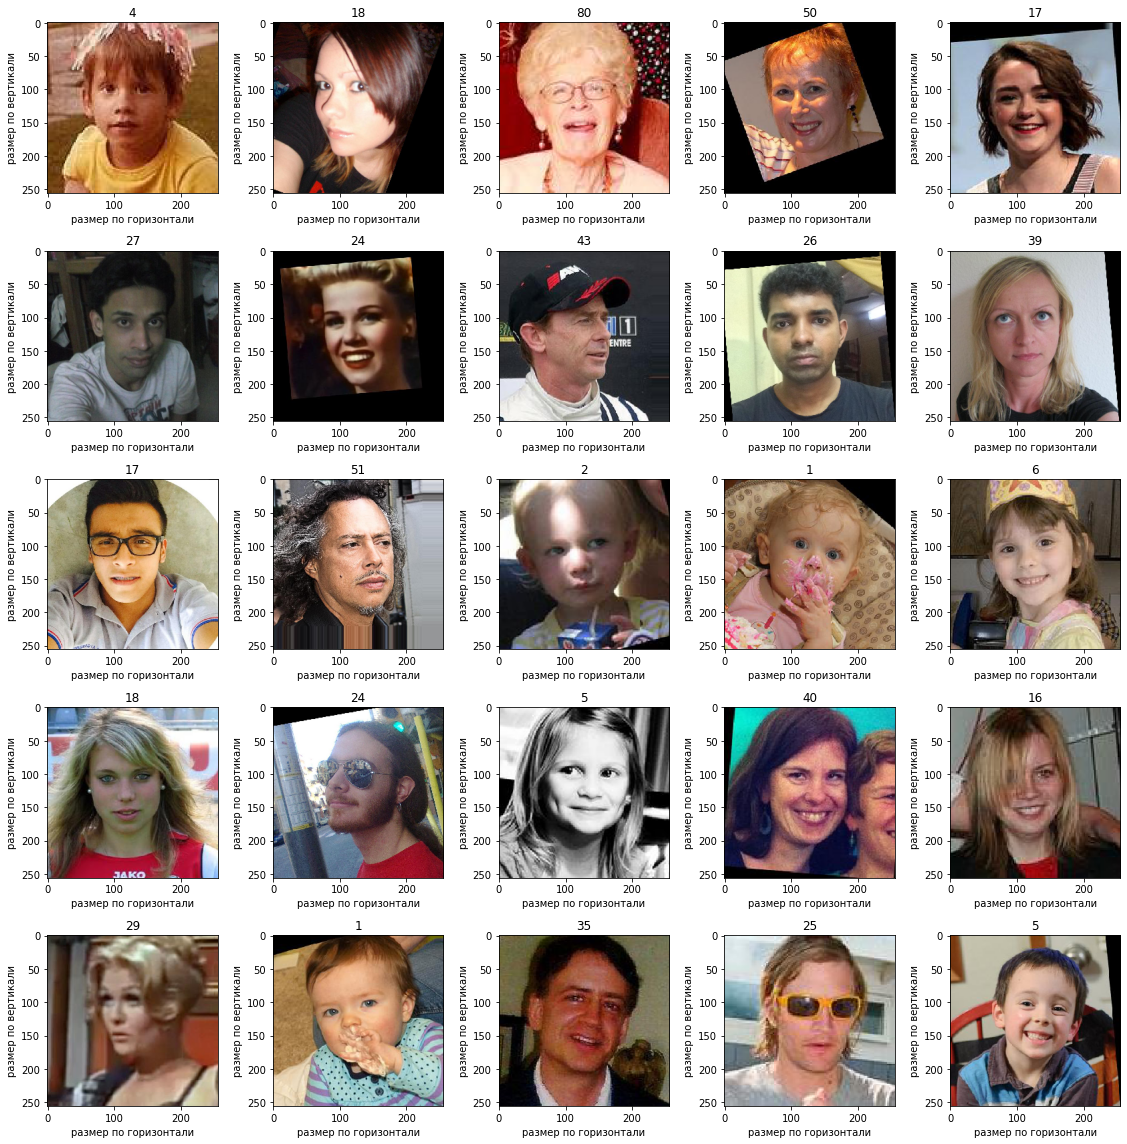

In [4]:
datagen = ImageDataGenerator(rescale=1/255)

datagen_flow = datagen.flow_from_directory('/datasets/faces/', shuffle=False)

features, target = next(datagen_flow) 

# выводим 25 изображений
fig = plt.figure(figsize=(16,16))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(labels['real_age'][i])
    plt.xlabel('размер по горизонтали')
    plt.ylabel('размер по вертикали')    
    plt.tight_layout()

Выведенные на экран фотографии предподготовлены и уже ориентированы вертикально, т.е. отражают естесственное положение человека в общественном месте типа магазина, кафе и пр. В случае с фото людей, которые пришли в супермаркет, а не покататься на атракционах, при изменении фото с целью увеличения выборки не стоит прибегать к вертикальному отзеркаливанию или повороту, т.к. это не является естесственным положением лица, что может сбить модель и способствовать ее переобучению. Поэтому, далее при обучении модели был применен только механизм горизонтального отзеркаливания.

В выведенных на экран фотографиях имеются черно-белые фото, что также может сказаться на низком качестве обучаемости модели, при условии, что камера в супермаркете записывает цветное изображение. 

Размеры изображений одинаковые.

## Обучение модели

**Код обучения модели в отдельном GPU-тренажёре:**

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
 
def load_train(path):
 
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255,
        horizontal_flip=True)
    labels = pd.read_csv(path + '/labels.csv') 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345)
 
    return train_datagen_flow
 
def load_test(path):
 
    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1./255)
    labels = pd.read_csv(path + '/labels.csv') 
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 1, activation='relu')) 
 
    optimizer = Adam(lr=0.0001)
 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size= None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 
```

```
# < Результат вывода на экран: >

Train for 190 steps, validate for 48 steps
Epoch 1/5
2022-06-29 12:34:49.681840: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-29 12:34:49.986303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 46s - loss: 250.0571 - mae: 11.1773 - val_loss: 838.9835 - val_mae: 23.9519
Epoch 2/5
190/190 - 38s - loss: 75.1111 - mae: 6.4929 - val_loss: 570.5357 - val_mae: 18.5403
Epoch 3/5
190/190 - 38s - loss: 51.3897 - mae: 5.4546 - val_loss: 257.2323 - val_mae: 11.6829
Epoch 4/5
190/190 - 38s - loss: 37.3065 - mae: 4.6308 - val_loss: 112.8555 - val_mae: 7.9053
Epoch 5/5
190/190 - 38s - loss: 30.3922 - mae: 4.1723 - val_loss: 70.3620 - val_mae: 6.3420

48/48 - 8s - loss: 70.3620 - mae: 6.3420
Test MAE: 6.3420

```

## Анализ обученной модели

В задачи работы входили анализ исходных данных и создание модели по определению возраста клиентов супермаркета «Хлеб-Соль» по фотографиям.

Представленное количество фотографий в исходных данных для обучения модели небольшое. Для реализации поставленной задачи наростили количество исходных данных путем горизонтального отзеркаливания.

Судя по графику распределения возраста в выборке представленые данные - корректные, аномальных значений по возрасту не выявлено. Представленное количество фотографий неравномерное по возрасту.

Загруженные фото имеют вертикальную ориентацию лица лчеловека, поэтому для обучения и проверки качества модели использовался только один вид аугументации - горизонтальное отзеркаливание.

Работа с большим количеством фотографий требует большого объема памяти, и реализация поставленной задачи на локальном компьютере не представляется возможным. В связи с этим, обучение модели было произведено в GPU-тренажёре. 

Для достижения высокого качества модели и достижения требуемой метрики МАЕ была выбрана модель, обученная на 80% и протестированная на 20% от всего объема данных. Для обучения модели применялась сверточная сеть. В модели использовались арихитектура RasNet с отсеченной верхушкой, которая была дополнена слоями GlobalAveragePooling2D() и Dense (всего 3 слоя). При этом Dense в настройках на выходе определяем один нейрон с целью получить на выходе только одно значение возраста для одной фотографии, настройка активации выбрана activation='relu' как подходящая для задачи регресии. Алгоритм обучения модели в данной конструкции - градиентный спуск. Для определения шага градиентного спуска был выбран алгоритм Adam. Опытным путем был определен шаг 0,0001. При компилировании модели функция потерь была выбрана 'mse', т.к. с ней модель обучается быстрее. 

Таким образом, требуемых результатов качества модели удалось получить с выше перечисленными настройками на 3 эпохах обучения. В итоге, модель для распознавания возраста по фотографиям имеет метрику MAE на тестовой выборке - 6.34.